In [28]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
%autoreload 2

In [208]:
import functools
import jax
import os
import pandas as pd
import mlflow
import pickle

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

# other envs
from task_aware_skill_composition.brax.envs.point import Point
from task_aware_skill_composition.brax.envs.car import Car
from task_aware_skill_composition.brax.envs.drone import Drone
from task_aware_skill_composition.brax.envs.point import Point
from task_aware_skill_composition.brax.envs.doggo import Doggo

# tasks
from task_aware_skill_composition.brax.tasks import get_task

In [118]:
from jaxgcrl.envs.ant_maze import AntMaze

In [119]:
mlflow.set_tracking_uri(f"file:///home/tassos/.local/share/mlflow")

In [209]:
backend = 'mjx'

# env = Car(backend=backend)
# env = Drone(backend=backend)
# env = Point(backend=backend)
# env = Doggo(backend=backend)

# env = envs.get_environment(env_name="reacher", backend=backend)
# env = AntMaze(backend=backend)

# task = get_task("point", "one_goal")
task = get_task("xy_point", "turn_seq")
env = task.env

spec = task.lo_spec
spec_tag = type(task).__name__
env_tag = type(env).__name__

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [200]:
env.action_size

2

# Plotting Utils

In [122]:
# xdata, ydata = [], []
# times = [datetime.now()]

def progress_fn(num_steps, metrics, df=None):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)
    
    # df.loc[num_steps] = {
    #     "time": datetime.now(),
    #     "eval/episode_reward": metrics['eval/episode_reward'],
    #     "eval/episode_robustness": metrics['eval/episode_robustness'] if 'eval/episode_robustness' in metrics else None, 
    #     "training/specification_loss": metrics['training/specification_loss'] if 'training/specification_loss' in metrics else None, 
    # }

# Defining STL

In [123]:
# import corallab_stl.expression_jax2 as stl
# import corallab_stl.expression_jax2_extra as stl_extra

In [124]:
# state_var = stl.Var("state", idx=0, dim=37, y_velocity=14)
# # moderate_y_vel = stl_extra.InBox(state_var.y_velocity, jnp.array([0.4]), jnp.array([25.0]))
# # always_moderate_y_vel = stl.STLUntimedAlways(moderate_y_vel)
# # eventually_always_moderate_y_vel = stl.STLUntimedEventually(always_moderate_y_vel)

# true = stl.STLPredicate(state_var, lambda s: 999, lower_bound=0.0)

# high_y_vel = stl.STLPredicate(state_var.y_velocity, lambda s: s[0], lower_bound=1.0)
# always_high_y_vel = stl.STLUntimedAlways(high_y_vel)
# eventually_high_y_vel = stl.STLUntimedEventually(high_y_vel)
# eventually_always_high_y_vel = stl.STLUntimedEventually(always_high_y_vel)

In [125]:
# state_var = stl.Var("state", idx=0, dim=29, position=(0, 2))

# def in_box_pred(x_min, x_max):
#     dim = x_min.shape[0]
#     neg_eye = -jnp.eye(dim)
#     pos_eye = jnp.eye(dim)
#     A = jnp.vstack((neg_eye, pos_eye))
#     b = jnp.concatenate((-x_min, x_max))
        
#     def in_box(s):
#         x = b - jnp.matmul(A, s)
#         return jnp.min(x, axis=-1)

#     return in_box

# in_region_1 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([3.0, 3.0]), jnp.array([4.0, 4.0])),
#     0.1
# )

# in_region_2 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([-4.0, 3.0]), jnp.array([-3.0, 4.0])),
#     0.1
# )

# in_region_3 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([1.5, 1.5]), jnp.array([2.5, 2.5])),
#     0.0
# )

# phi = stl.STLAnd(
#     stl.STLUntimedEventually(
#         stl.STLAnd(
#             in_region_1,
#             stl.STLNext(stl.STLUntimedEventually(in_region_2)),
#         )
#     ),
#     stl.STLUntimedAlways(stl.STLNegation(in_region_3))
# )

# phi({ state_var.idx: jnp.array([[0.0, 0.0],
#                                 [3.0, 0.0],
#                                 [3.5, 3.0],
#                                 [3.5, 3.5],
#                                 [-3.5, 3.5]]) })

# in_region_1 = stl.STLPredicate(state_var.position, lambda s: s

# high_y_vel = stl.STLPredicate(state_var.y_velocity, lambda s: s[0], lower_bound=1.0)
# always_high_y_vel = stl.STLUntimedAlways(high_y_vel)
# eventually_always_high_y_vel = stl.STLUntimedEventually(high_y_vel)

# Training

In [126]:
from task_aware_skill_composition.brax.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac
from brax.training.agents.apg import train as apg
from task_aware_skill_composition.brax.agents.dscrl import train as dscrl
from task_aware_skill_composition.brax.agents.ppo_with_spec_rewards import train as ppo_spec

def training_run(run_id, env, seed, train_fn=ppo.train, hyperparameters={}, extras={}):
    hyperparameters = {
        **hyperparameters,
        "seed": seed,
    }

    mlflow.log_params(hyperparameters)

    train_fn = functools.partial(train_fn, **hyperparameters)
    
    make_inference_fn, params, _ = train_fn(
        environment=env,
        progress_fn=functools.partial(progress_fn),
        seed=seed,
        **extras
    )

    with mlflow.MlflowClient()._log_artifact_helper(run_id, f'policy_params') as tmp_path:
        model.save_params(tmp_path, params)

    return make_inference_fn, params

## Training Policy with PPO

In [127]:
ppo_hps = {
    "num_timesteps": 50_000_000,
    "num_evals": 10,
    "reward_scaling": 10,
    "episode_length": 1000,
    "normalize_observations": True,
    "action_repeat": 1,
    "unroll_length": 5,
    "num_minibatches": 32,
    "num_updates_per_batch": 4,
    "discounting": 0.97,
    "learning_rate": 3e-4,
    "entropy_cost": 1e-2,
    "num_envs": 4096,
    "batch_size": 2048,
}

In [128]:
mlflow.set_experiment("proj2-ppo")

# spec = eventually_always_high_y_vel
# spec_tag = "eventually_always_high_y_vel"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo.train,
            hyperparameters=ppo_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040


## Training Policy with SAC

In [149]:
sac_hps = {
    "num_timesteps": 6_553_600,
    "num_evals": 20,
    "reward_scaling": 30,
    "episode_length": 1000,
    "normalize_observations": True,
    "action_repeat": 1,
    "discounting": 0.997,
    "learning_rate": 6e-4,
    "num_envs": 128,
    "batch_size": 512,
    "grad_updates_per_step": 64,
    "max_devices_per_host": 1,
    "max_replay_size": 1048576,
    "min_replay_size": 8192
}


In [150]:
mlflow.set_experiment("proj2-sac")

# spec = eventually_always_high_y_vel
# spec_tag = "eventually_always_high_y_vel"

spec = true
spec_tag = "true"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            seed,
            train_fn=sac.train,
            hyperparameters=sac_hps,
            # extras={
            #     "specification": spec,
            #     "state_var": state_var,
            # }
        )

NameError: name 'true' is not defined

## Training Policy with APG

In [49]:
apg_hps = {
    "policy_updates": 200,
    "episode_length": 100,
    "action_repeat": 4,
    "num_envs": 16,
    "learning_rate": 3e-3,
    "num_evals": 200
}

In [50]:
mlflow.set_experiment("proj2-apg-ant")

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            seed,
            train_fn=apg.train,
            hyperparameters=apg_hps
        )

Logging for 0
Logging for 1
Logging for 2
Logging for 3
Logging for 4
Logging for 5
Logging for 6
Logging for 7
Logging for 8
Logging for 9
Logging for 10
Logging for 11
Logging for 12
Logging for 13
Logging for 14
Logging for 15
Logging for 16
Logging for 17
Logging for 18
Logging for 19
Logging for 20
Logging for 21
Logging for 22
Logging for 23
Logging for 24
Logging for 25
Logging for 26
Logging for 27
Logging for 28
Logging for 29
Logging for 30
Logging for 31
Logging for 32
Logging for 33
Logging for 34
Logging for 35
Logging for 36
Logging for 37
Logging for 38
Logging for 39
Logging for 40
Logging for 41
Logging for 42
Logging for 43
Logging for 44
Logging for 45
Logging for 46
Logging for 47
Logging for 48
Logging for 49
Logging for 50
Logging for 51
Logging for 52
Logging for 53
Logging for 54
Logging for 55
Logging for 56
Logging for 57
Logging for 58
Logging for 59
Logging for 60
Logging for 61
Logging for 62
Logging for 63
Logging for 64
Logging for 65
Logging for 66
Loggi

## Training Policy with DSCRL

In [26]:
dscrl_hps = {
    "num_timesteps": 10_000_000,
    "num_evals": 10,
    "reward_scaling": 10,
    "episode_length": 1000,
    "normalize_observations": True,
    "action_repeat": 1,
    "unroll_length": 5,
    "num_minibatches": 32,
    "num_updates_per_batch": 4,
    "discounting": 0.97,
    "learning_rate": 3e-4,
    "entropy_cost": 1e-2,
    "specification_cost": 100,
    "num_envs": 2048,
    "batch_size": 512,
}

In [27]:
mlflow.set_experiment("proj2-dscrl")

spec = eventually_high_y_vel
spec_tag = "eventually_high_y_vel"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            seed,
            train_fn=dscrl.train,
            hyperparameters=dscrl_hps,
            extras={
                "specification": spec,
                "state_var": state_var,
            }
        )

Logging for 0
Logging for 1146880
Logging for 2293760
Logging for 3440640
Logging for 4587520
Logging for 5734400
Logging for 6881280
Logging for 8028160
Logging for 9175040
Logging for 10321920


## Training Policy with PPO + STL Rewards

In [136]:
ppo_spec_hps = {
    "num_timesteps": 50_000_000,
    "num_evals": 10,
    "reward_scaling": 10,
    "episode_length": 1000,
    "normalize_observations": True,
    "action_repeat": 1,
    "unroll_length": 5,
    "num_minibatches": 32,
    "num_updates_per_batch": 4,
    "discounting": 0.97,
    "learning_rate": 3e-4,
    "entropy_cost": 1e-2,
    "num_envs": 4096,
    "batch_size": 2048,
}

In [137]:
from task_aware_skill_composition.brax.envs.wrappers.specification_reward_wrapper import SpecificationRewardWrapper

In [138]:
mlflow.set_experiment("proj2-ppo-spec")

spec_wrapped_env = SpecificationRewardWrapper(
    env,
    spec,
    task.obs_var,
    rho_weight=1.0
)

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            spec_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters=ppo_spec_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040


## Training Policy with PPO + Automaton State

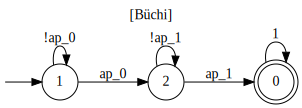

In [139]:
from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper

automaton_wrapped_env = AutomatonWrapper(
    env,
    spec,
    task.obs_var,
    augment_obs = True
)

automaton_wrapped_env.automaton.automaton

In [140]:
# from task_aware_skill_composition.brax.agents.tasc import train as tasc

ppo_automaton_hps = {
    "num_timesteps": 10_000_000,
    "num_evals": 10,
    "reward_scaling": 10,
    "episode_length": 1000,
    "normalize_observations": True,
    "action_repeat": 1,
    "unroll_length": 5,
    "num_minibatches": 32,
    "num_updates_per_batch": 4,
    "discounting": 0.97,
    "learning_rate": 3e-4,
    "entropy_cost": 1e-2,
    "num_envs": 4096,
    "batch_size": 2048,
}

In [141]:
mlflow.set_experiment("proj2-ppo-automaton")

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters=ppo_automaton_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 1310720
Logging for 2621440
Logging for 3932160
Logging for 5242880
Logging for 6553600
Logging for 7864320
Logging for 9175040
Logging for 10485760
Logging for 11796480


## Training with PPO + Automaton Transition Rewards

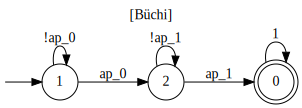

In [241]:
from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper
from task_aware_skill_composition.brax.envs.wrappers.automaton_transition_rewards_wrapper import AutomatonTransitionRewardsWrapper

automaton_wrapped_env = AutomatonWrapper(
    env,
    spec,
    task.obs_var,
    augment_obs = True
)

automaton_wrapped_env = AutomatonTransitionRewardsWrapper(
    automaton_wrapped_env
)

automaton_wrapped_env.automaton.automaton

In [242]:
mlflow.set_experiment("proj2-ppo-automaton-rewards")

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters=ppo_automaton_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 1310720
Logging for 2621440
Logging for 3932160
Logging for 5242880
Logging for 6553600
Logging for 7864320
Logging for 9175040
Logging for 10485760
Logging for 11796480


## Training with "TASC" (WIP)

In [ ]:
mlflow.set_experiment("proj2-tasc-ant-navigation")

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            seed,
            train_fn=tasc.train,
            hyperparameters=tasc_hps,
            extras={
                "specification": task.lo_spec,
                "state_var": task.obs_var,
            }
        )

## Training with CRL

In [12]:
crl_hps = {
    "num_timesteps": 1000000,
    "max_replay_size": 10000,
    "min_replay_size": 1000,
    "num_evals": 50,
    "episode_length": 1000,
    "action_repeat": 1,
    "discounting": 0.99,
    "num_envs": 512,
    "batch_size": 256,
    "unroll_length": 62,
    "multiplier_num_sgd_steps": 1,
    # "env_name": "reacher",
    "normalize_observations": False,
    "policy_lr": 6e-4,
    "alpha_lr": 3e-4,
    "critic_lr": 3e-4,
    "contrastive_loss_fn": 'infonce_backward',
    "energy_fn": 'l2',
    # "backend": None,
    # "no_resubs": False,
    "use_ln": False,
    "use_c_target": False,
    "logsumexp_penalty": 0.0,
    "l2_penalty": 0.0,
    "exploration_coef": 0.0,
    "random_goals": 0.0,
    # "log_wandb": False,
    "disable_entropy_actor": False,
    "eval_env": None,
    "h_dim": 256,
    "n_hidden": 2,
    "repr_dim": 64,
}

In [13]:
from jaxgcrl import train as crl

In [ ]:
mlflow.set_experiment("proj2-crl-ant-navigation")

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            seed,
            train_fn=crl.train,
            hyperparameters=crl_hps,
            # extras={
            #     "specification": task.lo_spec,
            #     "state_var": task.obs_var,
            # }
        )

# Plotting Everything

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from aim import Repo

In [25]:
repo = Repo("/home/tassos/.local/share/aim/")

In [26]:
def stack_columns(dfs, col_name):
    tmp = pd.concat([df[col_name].astype(float) for df in dfs], axis=1)
    return tmp

## DSCRL Lambda Sweep

See bookmark: http://127.0.0.1:8082/metrics/d8b65f06-96ec-11ef-b914-b5fb2ff9a352

run.hash in ["09316a37ebdb400b926ad00e","28e5894ef28f4fd3a6bc0cb3","2eeca304660a4ea7acfee000","b9cd3b375fa84b158d5c8eb4","ae15e6b4558e45d5aff3e761","059901cb7879451b8b232e83","5277fcd5cce843eca0a5cef1","bdd3fa9e3f4740a6ba649a56","78de90e8e6a249d7b4a478ac","52ebf197399644cba97adcdf","92126dabd70b41038633e62c","fe52d12a24a842f7aa0de17b","178b47f6251d4ecab71c3502","f2243c0453b24344ac2b6582","433c6c8581c74deba9126f9b","a054628b0b2b47ca80c3c605","c278537bf34345749af45687","3982a7b68ad04fb0a6ca5e97","def5fd83103045f593faacd2","65a3501be5a6485db1ff809d","87b19d1d04204fa0a2125642","69afadca7fdb4c35906be4bc","20b893da043b4d92bb68cd8e"] and metric.name == "eval/episode_robustness"

In [13]:
query = 'run.hash in ["09316a37ebdb400b926ad00e","28e5894ef28f4fd3a6bc0cb3","2eeca304660a4ea7acfee000","b9cd3b375fa84b158d5c8eb4","ae15e6b4558e45d5aff3e761","059901cb7879451b8b232e83","5277fcd5cce843eca0a5cef1","bdd3fa9e3f4740a6ba649a56","78de90e8e6a249d7b4a478ac","52ebf197399644cba97adcdf","92126dabd70b41038633e62c","fe52d12a24a842f7aa0de17b","178b47f6251d4ecab71c3502","f2243c0453b24344ac2b6582","433c6c8581c74deba9126f9b","a054628b0b2b47ca80c3c605","c278537bf34345749af45687","3982a7b68ad04fb0a6ca5e97","def5fd83103045f593faacd2","65a3501be5a6485db1ff809d","87b19d1d04204fa0a2125642","69afadca7fdb4c35906be4bc","20b893da043b4d92bb68cd8e"] and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

In [ ]:
robustness_cols = stack_columns(dfs, "value")
ax = sb.lineplot(data=robustness_cols)

## PPO with Normal Reward + Specification Rewards

PPO trained with normal rewards plus specification rewards, using the specification "Eventually, Always have Y velocity in [0.4, 25]"

In [40]:
query = 'run.hash in ["1ecb3392ab1f496da5991804","98073c316fee42d2950ea7d5","7bbc9c0227374793afc081be"] and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

100% 77/77 [00:00<00:00, 773.63it/s]


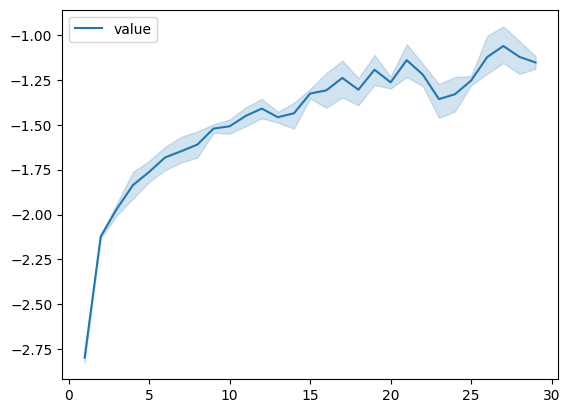

In [41]:
robustness_cols = stack_columns(dfs, "value")
ax = sb.lineplot(data=robustness_cols)

## PPO with Specification Rewards and no +x rewards

In [27]:
query = 'run.experiment == "proj2-ppo-with-spec-no-forward" and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

100% 82/82 [00:00<00:00, 627.58it/s]


In [30]:
robustness_cols

,value,value,value
0,-3.080169,-3.088458,-3.133463
1,-0.617292,-0.662224,-0.635249
2,-0.628243,-0.608660,-0.613961
3,-0.575037,-0.622679,-0.571571
4,-0.557550,-0.598696,-0.579039
5,-0.618358,-0.610716,-0.580789
6,-0.545638,-0.557603,-0.594481
7,-0.587184,-0.591671,-0.576341
8,-0.590163,-0.597341,-0.585975
9,-0.595478,-0.583906,-0.581572


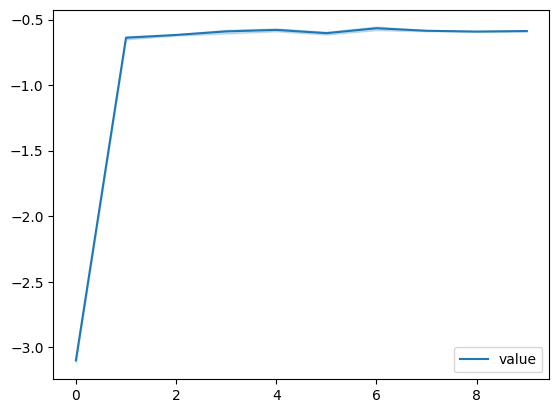

In [29]:
robustness_cols = stack_columns(dfs, "value")
ax = sb.lineplot(data=robustness_cols)

## Comparing DSCRL with Specification Rewards

In [ ]:
query = 'run.experiment == "proj2-ppo-with-spec-no-forward" and metric.name == "eval/episode_robustness"'

dfs = []

# Convert results into pandas dataframe
for run_metrics_col in repo.query_metrics(query).iter_runs():
    df = run_metrics_col.dataframe(only_last=False, include_run=False)
    if df is not None:
        dfs.append(df)
        # display(df.value)

## Old Plots

In [ ]:
query = 'run.hash in ["09316a37ebdb400b926ad00e","28e5894ef28f4fd3a6bc0cb3","2eeca304660a4ea7acfee000","b9cd3b375fa84b158d5c8eb4","ae15e6b4558e45d5aff3e761","059901cb7879451b8b232e83","5277fcd5cce843eca0a5cef1","bdd3fa9e3f4740a6ba649a56","78de90e8e6a249d7b4a478ac","52ebf197399644cba97adcdf","92126dabd70b41038633e62c","fe52d12a24a842f7aa0de17b","178b47f6251d4ecab71c3502","f2243c0453b24344ac2b6582","433c6c8581c74deba9126f9b","a054628b0b2b47ca80c3c605","c278537bf34345749af45687","3982a7b68ad04fb0a6ca5e97","def5fd83103045f593faacd2","65a3501be5a6485db1ff809d","87b19d1d04204fa0a2125642","69afadca7fdb4c35906be4bc","20b893da043b4d92bb68cd8e"] and metric.name == "eval/episode_robustness"'

In [ ]:
ppo_reward_cols = stack_columns(ppo_dfs, "eval/episode_reward")

In [ ]:
ppo_stacked_reward_df = pd.concat([ppo_dfs[i]["eval/episode_reward"][1:].astype(float) for i in range(1, 5)], axis=1)
ppo_stacked_reward_df

<Axes: >

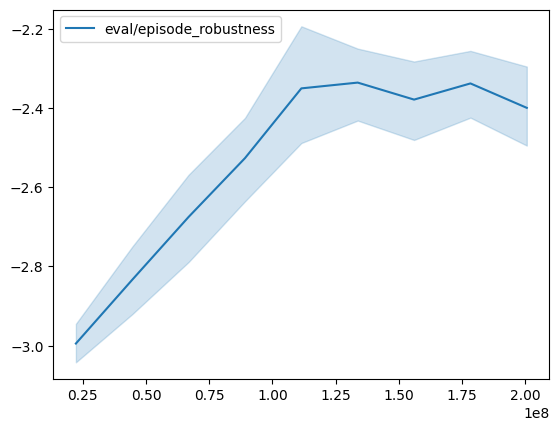

In [42]:
dscrl_robustness_cols = stack_columns(dscrl_dfs, "eval/episode_robustness")
dscrl_robustness_cols
sb.lineplot(data=dscrl_robustness_cols)

<Axes: >

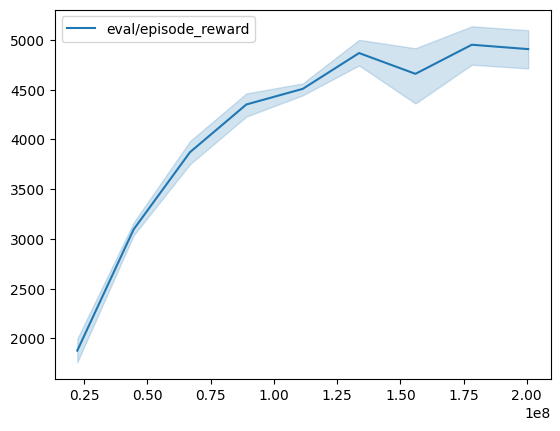

In [45]:
dscrl_reward_cols = stack_columns(dscrl_dfs, "eval/episode_reward")
dscrl_reward_cols
sb.lineplot(data=dscrl_reward_cols)

<Axes: >

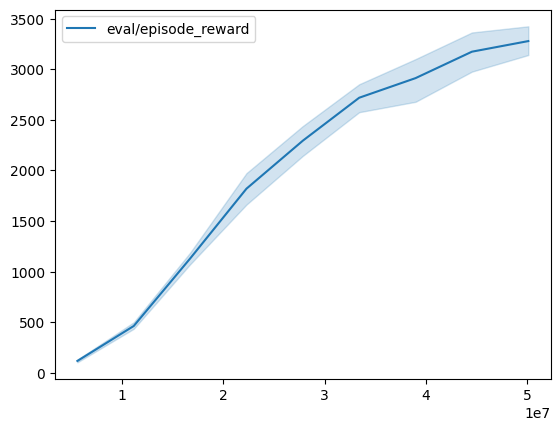

In [74]:
sb.lineplot(data=ppo_stacked_reward_df)

In [ ]:
ppo_dfs[2]

In [43]:
import numpy as np
stacked_rhos = np.stack([dscrl_dfs[i]["eval/episode_robustness"][1:].astype(float).values for i in range(1, 5)])

array([0.3235376 , 0.28964373, 0.30127877, 0.30192887, 0.30027927,
       0.29673601, 0.28510986, 0.27272451, 0.26550546])

In [62]:
# stacked_rhos.mean(axis=0)

# stacked_rhos_df = pd.DataFrame(stacked_rhos)
stacked_rhos_df = pd.concat([dscrl_dfs[i]["eval/episode_robustness"][1:].astype(float) for i in range(1, 5)], axis=1)
#stacked_rhos_df = stacked_rhos_df.reset_index(names="timesteps")
stacked_rhos_df

,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness
5570560,0.323969,0.320445,0.328287,0.321449
11141120,0.294844,0.289531,0.293048,0.281152
16711680,0.301107,0.297324,0.312667,0.294018
22282240,0.293684,0.286127,0.322109,0.305796
27852800,0.276426,0.277469,0.319472,0.327749
33423360,0.266103,0.269162,0.317470,0.334210
38993920,0.251890,0.264955,0.304999,0.318595
44564480,0.228068,0.251262,0.293618,0.317951
50135040,0.215680,0.239677,0.287422,0.319243


In [63]:
stacked_rhos_df.head()


,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness,eval/episode_robustness
5570560,0.323969,0.320445,0.328287,0.321449
11141120,0.294844,0.289531,0.293048,0.281152
16711680,0.301107,0.297324,0.312667,0.294018
22282240,0.293684,0.286127,0.322109,0.305796
27852800,0.276426,0.277469,0.319472,0.327749


Text(0.5, 0, 'timesteps')

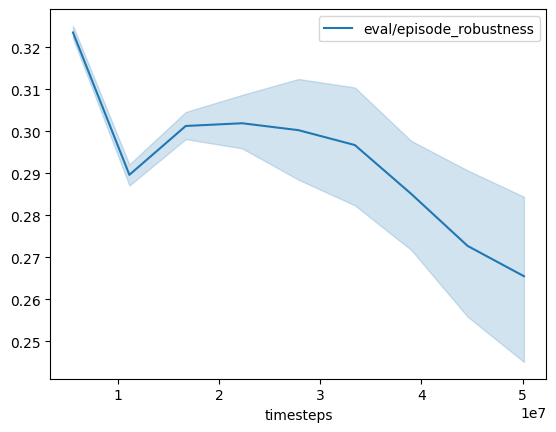

In [70]:
ax = sb.lineplot(data=stacked_rhos_df)
ax.set_xlabel("timesteps")

In [65]:
stacked_reward_df = pd.concat([dscrl_dfs[i]["eval/episode_reward"][1:].astype(float) for i in range(1, 5)], axis=1)
stacked_reward_df

,eval/episode_reward,eval/episode_reward,eval/episode_reward,eval/episode_reward
5570560,116.415878,140.420746,101.707825,103.423035
11141120,419.237457,472.448059,529.364807,374.440613
16711680,984.487061,1105.554932,834.572327,1073.442383
22282240,1892.635986,1987.755127,1456.529785,1756.829834
27852800,2206.142090,2453.418701,1829.139404,2520.385742
33423360,2928.383057,2770.024658,1929.486572,2954.229004
38993920,3234.015625,3038.151855,2184.994141,3275.265137
44564480,3079.635254,3298.819336,2712.125000,3084.580811
50135040,3428.739746,3012.038574,2966.310303,3732.254883


<Axes: >

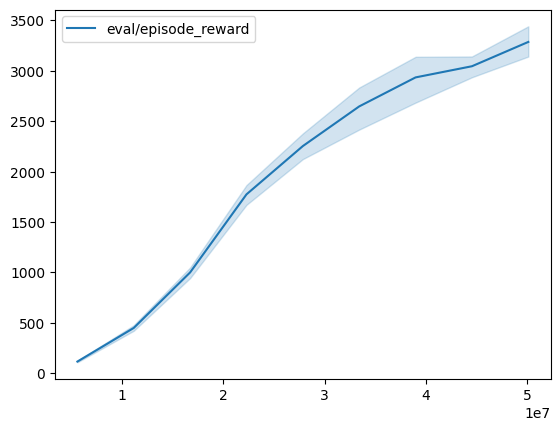

In [67]:
sb.lineplot(data=stacked_reward_df)

# Visualizing Policy

In [243]:
# If using a policy considering the automaton
automaton_wrapped_env
jit_reset = jax.jit(automaton_wrapped_env.reset)
jit_step = jax.jit(automaton_wrapped_env.step)

In [244]:
# reset the environment
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)

In [245]:
state.obs.shape

(7,)

In [246]:
env.action_size

2

## Loading from a previous run

In [187]:
from brax.training.agents.ppo import networks as ppo_networks
from jaxgcrl import networks as crl_networks
from brax.training.acme import running_statistics

In [188]:
training_run_id = "d885ebc2a4694a8bac32663a61c55f39"
logged_model_path = f'runs:/{training_run_id}/policy_params'
real_path = mlflow.artifacts.download_artifacts(logged_model_path)
params = model.load_params(real_path)
# normalizer_params, policy_params = model.load_params(real_path)
# normalizer_params, policy_params, crl_critic_params = model.load_params(real_path)

In [189]:
run = mlflow.get_run(run_id=training_run_id)
if run.data.params["normalize_observations"] == "True":
    normalize = running_statistics.normalize
else:
    normalize = lambda x, y: x

In [190]:
# Making the network
ppo_network = ppo_networks.make_ppo_networks(
      state.obs.shape[0],
      env.action_size,
      preprocess_observations_fn=normalize
)
make_policy = ppo_networks.make_inference_fn(ppo_network)

# # Making the network
# crl_network = crl_networks.make_crl_networks(
#     env=env,
#     observation_size=env.observation_size,
#     action_size=env.action_size,
#     repr_dim=run.data.params["repr_dim"],
#     preprocess_observations_fn=normalize,
#     hidden_layer_sizes=[int(run.data.params["h_dim"])] * int(run.data.params["n_hidden"]),
#     use_ln=bool(run.data.params["use_ln"]),
# )
# make_policy = crl_networks.make_inference_fn(crl_network)

## Or from the most recent run from the current session

In [247]:
make_policy = make_inference_fn

In [248]:
inference_fn = make_policy(params)
jit_inference_fn = jax.jit(inference_fn)

In [249]:
ctrl = jnp.array([0.0, 1.0])

# grab a trajectory acting according to the policy function
rollout = [state]
actions = []
n_steps = 200
render_every = 1

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)

    if state.done:
        break

    # print(type(state.pipeline_state))

    actions.append(ctrl)
    rollout.append(state)

In [250]:
mediapy.show_video(
    env.render(
        [s.pipeline_state for s in rollout],
        camera='overview'
    ), fps=1.0 / env.dt
)

In [ ]:
HTML(html.render(env.sys, [state.pipeline_state for state in rollout]))

In [251]:
position_traj = jnp.stack([state.obs[:2] for state in rollout])
automata_state_traj = jnp.stack([state.info["automata_state"] for state in rollout])
good_edge_satisfaction_state_traj = jnp.stack([state.info["good_edge_satisfaction"] for state in rollout])
delta_good_edge_satisfaction_state_traj = jnp.stack([state.info["delta_good_edge_satisfaction"] for state in rollout])
reward_traj = jnp.stack([state.reward for state in rollout])

#from jax.numpy.linalg import norm

# print(norm(position_traj - jnp.array([2.0, 0.0]), axis=1))
# print(delta_good_edge_satisfaction_state_traj)
# automaton_wrapped_env.automaton.one_hot_decode(observations[:, -3:])

In [253]:
automata_state_traj

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

In [166]:
# automata_state_traj
# good_edge_satisfaction_state_traj

# jnp.set_printoptions(precision=1)
# jnp.stack([automata_state_traj,
#            delta_good_edge_satisfaction_state_traj])

Array([[ 1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,
         1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,
         1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,
         1.0e+00,  1.0e+00,  1.0e+00,  1.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00,
         2.0e+00,  2.0e+00,  2.0e+00,  2.0e+00, 

# Testing Value Gradients

In [159]:
rng = jax.random.PRNGKey(0)

In [160]:
# from brax.training import acting

# policy = make_policy(params)

# end_state, data = acting.generate_unroll(
#     env,
#     state,
#     policy,
#     rng,
#     16,
# )

In [161]:
# Learning simple model and optimizing policy using stl gradient computed through the model

# end_state.obs.shape

# data.next_observation[-2] == data.observation[-1]

# Focus only on STL rewards / gradients

In [162]:
# type(rollout[2])

In [172]:
state = rollout[0]

action, info = jit_inference_fn(state.obs, rng)
nstate = jit_step(state, action)
nstate

State(pipeline_state=State(ne=np.int64(0), nf=np.int64(0), nl=np.int64(8), nefc=np.int64(24), ncon=4, solver_niter=Array(0, dtype=int32), time=Array(0.05, dtype=float32), qpos=Array([ 0.0139529 , -0.03996074,  0.63675785,  0.99378055, -0.05538768,
        0.00199552,  0.09658413,  0.04228359,  1.0120703 , -0.08042864,
       -0.8293523 ,  0.02364826, -0.9313298 ,  0.0309616 ,  0.90521836],      dtype=float32), qvel=Array([-0.2737144 , -0.3045395 , -0.20280352,  0.9305872 , -1.739072  ,
        0.17524782,  0.90404856,  2.1480591 , -2.9081254 ,  3.1281977 ,
        0.18233581,  1.9462949 , -0.9218488 , -1.5325208 ], dtype=float32), act=Array([], shape=(0,), dtype=float32), qacc_warmstart=Array([  0.3756814,  -1.4559944, -10.069819 ,   6.1503577, -20.883118 ,
         3.2809033,  21.114697 ,  41.881245 , -59.65444  ,  61.808647 ,
         5.1704125,  43.096153 , -16.689274 , -31.978033 ], dtype=float32), ctrl=Array([-0.11716611, -0.22408305,  0.15158291,  0.2960523 , -0.42053863,
       